# 第五章：对未标记数据进行预训练

本章节中中使用的软件包：

In [232]:
from importlib.metadata import version

pkgs = ["matplotlib", 
        "numpy", 
        "transformers", 
        "torch",
        "tensorflow" # For OpenAI's pretrained weights
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.9.2
numpy version: 1.26.4
transformers version: 4.46.3
torch version: 2.5.1
tensorflow version: 2.18.0


- 在本章中，我们实现了训练和基本模型评估代码来预训练 LLM

## 5.1 评估生成文本模型

- 本节首先简要回顾如何使用上一章的代码初始化 GPT 模型
- 然后，我们讨论 LLM 的基本评估指标
- 最后，在本节中，我们将这些评估指标应用于训练和验证数据集

### 5.1.1 使用GPT生成文本

- 我们使用上一章的代码初始化 GPT 模型

In [233]:
import torch
from previous_chapters import GPTModel
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")

GPT_CONFIG_124M = {
    "vocab_size": len(tokenizer),   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(42)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

- 我们在上面使用了 0.1 的 dropout，但现在训练 LLM 时不使用 dropout 比较常见
- 现代 LLM 也不在 `nn.Linear` 层中对查询、键和值矩阵使用偏差向量（与早期的 GPT 模型不同），这是通过设置 `"qkv_bias": False` 来实现的
- 我们将上下文长度（`context_length`）减少到仅 256 个 token，以减少训练模型的计算资源要求，而原始的 1.24 亿参数 GPT-2 模型使用了 1024 个 token
- 这样做是为了让更多的读者能够在他们的笔记本电脑上关注和执行代码示例
- 但是，请随意将 `context_length` 增加到 1024 个 token
- 我们稍后还将从预训练权重中加载一个具有 1024 个 `context_length` 的模型

- 接下来，我们使用上一章中的 `generate_text_simple` 函数来生成文本
- 此外，我们定义了两个便利函数，`text_to_token_ids` 和 `token_ids_to_text`，用于在本章中使用的标记和文本表示之间进行转换

In [234]:
from transformers import BertTokenizer
from previous_chapters import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, max_length=None, truncation=False)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist(), skip_special_tokens=True, clean_up_tokenization_spaces=True)

start_context = "每一次努力都让你感动"
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=30,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 每 一 次 努 力 都 让 你 感 动 慎 鎖笞 熬rn ย 😂 鼾 茹學ⓒ 纨 劑 1b 帅身 x7 θ鳅 amg 翻200sday 浴いて ios10 nokia 1918 愛 pixnetfacebookyahoo


- 如上所示，由于模型尚未经过训练，因此无法生成优质文本
- 我们如何以数字形式测量或捕捉“优质文本”，以便在训练期间进行跟踪？
- 下一小节将介绍用于计算生成输出的损失指标的指标，我们可以使用这个指标来衡量训练进度
- 下一章关于微调 LLM 的内容还将介绍其他衡量模型质量的方法

### 5.1.2 计算文本生成损失：交叉熵和困惑度

- 假设我们有一个“输入”张量，其中包含 2 个训练示例（行）的标记 ID
- 与“输入”相对应，“目标”包含我们希望模型生成的所需标记 ID
- 请注意，“目标”是移动 1 个位置的“输入”，如第 2 章我们实现数据加载器时所述

In [ ]:
# print(tokenizer.encode("每一次努力都让你感动", add_special_tokens=False))
# print(tokenizer.encode("我真的非常喜欢巧克力", add_special_tokens=False))

# print(tokenizer.decode([3680, 671,  3613, 1222, 1213, 6963, 6375, 872,  2697], add_special_tokens=False))
# print(tokenizer.decode([2769, 4696, 4638, 7478, 2382, 1599, 3614, 2341, 1046], add_special_tokens=False))
# print(tokenizer.decode([671,  3613, 1222, 1213, 6963, 6375, 872, 2697,  1220], add_special_tokens=False))
# print(tokenizer.decode([4696, 4638, 7478, 2382, 1599, 3614, 2341, 1046, 1213], add_special_tokens=False))

[3680, 671, 3613, 1222, 1213, 6963, 6375, 872, 2697, 1220]
[2769, 4696, 4638, 7478, 2382, 1599, 3614, 2341, 1046, 1213]
每 一 次 努 力 都 让 你 感
我 真 的 非 常 喜 欢 巧 克
一 次 努 力 都 让 你 感 动
真 的 非 常 喜 欢 巧 克 力


In [235]:
inputs = torch.tensor([[3680,  671,  3613, 1222, 1213, 6963, 6375, 872,  2697],   # ["每一次努力都让你感",
                       [2769,  4696, 4638, 7478, 2382, 1599, 3614, 2341, 1046]])   #  "我真的非常喜欢巧克"]

targets = torch.tensor([[671,  3613, 1222, 1213, 6963, 6375, 872, 2697,  1220],  # ["一次努力都让你感动",
                        [4696, 4638, 7478, 2382, 1599, 3614, 2341, 1046, 1213]]) #  "真的非常喜欢巧克力"]

- 将“输入”输入到模型中，我们获得 2 个输入示例的 logits 向量，每个示例由 9 个标记组成
- 每个标记都是一个 21,128 维向量，与词汇表的大小相对应
- 应用 softmax 函数，我们可以将 logits 张量转换为包含概率分数的相同维度的张量

In [236]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 9, 21128])


- 如上一章所述，我们可以应用 `argmax` 函数将概率分数转换为预测的 token ID
- 上面的 softmax 函数为每个 token 生成一个 21,128 维向量；`argmax` 函数返回此向量中最高概率分数的位置，即给定 token 的预测 token ID
- 由于我们有 2 个输入批次，每个批次有 3 个标记，因此我们获得 2 乘 3 的预测标记 ID：

In [237]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[20213],
         [ 1357],
         [14017],
         [10361],
         [  652],
         [13444],
         [10938],
         [17176],
         [ 7797]],

        [[18073],
         [ 8195],
         [ 5818],
         [  986],
         [10773],
         [20497],
         [  234],
         [19857],
         [15688]]])


- 如果我们解码这些标记，我们会发现它们与我们希望模型预测的标记（即目标标记）有很大不同：

In [238]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1: 一 次 努 力 都 让 你 感 动
Outputs batch 1: ##钒 取倪ae ㄌน 285灏 魚


- 这是因为模型尚未经过训练
- 为了训练模型，我们需要知道它距离正确的预测（目标）有多远

- 目标索引对应的token概率如下：

In [240]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2, 3, 4, 5, 6, 7, 8], targets[text_idx]]
print("第一个文本:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2, 3, 4, 5, 6, 7, 8], targets[text_idx]]
print("第二个文本:", target_probas_2)

第一个文本: tensor([4.1327e-05, 8.7313e-05, 3.3802e-05, 2.7975e-05, 3.3695e-05, 3.4557e-05,
        1.5627e-05, 3.4214e-05, 3.7327e-05])
第二个文本: tensor([8.4292e-05, 1.9261e-05, 1.3799e-05, 1.1468e-04, 2.1015e-05, 4.4112e-05,
        5.4746e-05, 4.3250e-05, 3.5221e-05])


- 我们希望最大化所有这些值，使它们的概率接近 1
- 在数学优化中，最大化概率分数的对数比最大化概率分数本身更容易；

In [241]:
# Compute logarithm of all token probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([-10.0940,  -9.3460, -10.2950, -10.4842, -10.2982, -10.2729, -11.0665,
        -10.2829, -10.1958,  -9.3812, -10.8575, -11.1909,  -9.0733, -10.7703,
        -10.0288,  -9.8128, -10.0485, -10.2539])


- 接下来，我们计算平均对数概率：

In [242]:
# Calculate the average probability for each token
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.2085)


- 目标是通过优化模型权重使这个平均对数概率尽可能大
- 由于对数，最大可能值为 0，而我们目前距离 0 还很远

- 在深度学习中，标准惯例是最小化*负*平均对数概率值，而不是最大化平均对数概率值；在我们的例子中，在深度学习中，我们不会最大化 -10.7722 以使其接近 0，而是会最小化 10.7722 以使其接近 0
- -10.7722 的负值，即 10.7722，在深度学习中也称为交叉熵损失

In [243]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.2085)


- PyTorch 已经实现了一个 `cross_entropy` 函数来执行前面的步骤

- 在应用“cross_entropy”函数之前，让我们检查一下 logits 和目标的形状

In [244]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 9, 21128])
Targets shape: torch.Size([2, 9])


- 对于 PyTorch 中的 `cross_entropy` 函数，我们希望通过在批量维度上组合这些张量来展平它们：

In [245]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([18, 21128])
Flattened targets: torch.Size([18])


- 请注意，目标是标记 ID，它们也代表我们想要最大化的 logits 张量中的索引位置
- PyTorch 中的 `cross_entropy` 函数将自动负责在要最大化的 logits 中的标记索引上内部应用 softmax 和对数概率计算

In [246]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.2085)


- 与交叉熵损失相关的一个概念是 LLM 的困惑度
- 困惑度只是交叉熵损失的指数

In [247]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(27132.2910)


- 困惑度通常被认为更具可解释性，因为它可以理解为模型在每个步骤中不确定的有效词汇量（在上面的例子中，即 27,132 个字或标记）
- 换句话说，困惑度衡量了模型预测的概率分布与数据集中单词的实际分布的匹配程度
- 与损失类似，困惑度越低，表示模型预测越接近实际分布

### 5.1.3 计算训练集和验证集损失

- 我们使用相对较小的数据集来训练 LLM（实际上，只有一个短篇故事）
- 原因是：
  - 您可以在没有合适 GPU 的笔记本电脑上几分钟内运行代码示例
  - 训练完成相对较快（几分钟而不是几周），这对于教育目的很有帮助
  - 我们使用来自公共领域的文本，可以将其包含在此 GitHub 存储库中，而不会侵犯任何使用权或增加存储库大小

- 例如，Llama 2 7B 需要在 A100 GPU 上花费 184,320 个 GPU 小时才能在 2 万亿个令牌上进行训练
  - 在撰写本文时，AWS 上 8xA100 云服务器的每小时成本约为 \$30
  - 因此，通过开箱即用的计算，训练这个 LLM 将花费 184,320 / 8 * \$30 = \$690,000

- 下面，我们使用与第 2 章相同的数据集

In [248]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/GavinHome/LLMs-from-scratch-zh/main/ch02/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

- 通过打印前 100 个字和后 100 个字来快速检查文本是否加载正常

In [249]:
# First 100 characters
print(text_data[:99])

我一直认为杰克·吉斯伯恩是一个廉价的天才——尽管他是个不错的家伙——所以当我听说他在事业巅峰时放弃了绘画，娶了一位富有的寡妇，并在里维埃拉的一座别墅里安顿下来时，我并不感到特别惊讶。（虽然我更倾向于


In [250]:
# Last 100 characters
print(text_data[-99:])

——只是在德文郡从一次心脏病发作恢复期间，用颤抖的手记录下的一个笔记。只是一个笔记！但它讲述了他的整个历史。每一笔都充满了多年的耐心而蔑视的坚持。随波逐流的人永远学不会那种强大的逆流而上的笔触……”


In [252]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 2806
Tokens: 2758


- 文本只有 2,758 个 token，对于训练 LLM 来说太短了，但同样，这是出于学习目的（我们稍后还将加载预训练的权重）

- 接下来，我们将数据集分为训练集和验证集，并使用第 2 章中的数据加载器为 LLM 训练准备批次
- 出于可视化目的，下图假设 `max_length=6`，但对于训练加载器，我们将 `max_length` 设置为 LLM 支持的上下文长度
- 下图仅显示输入标记以方便理解
  - 由于我们训练 LLM 来预测文本中的下一个单词，因此目标看起来与这些输入相同，只是目标移动了一个位置

In [253]:
from previous_chapters import create_dataloader_v1

# Train/validation ratio
train_ratio = 0.80
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [254]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

- 我们使用相对较小的批处理大小来减少计算资源需求，因为数据集一​​开始就很小
- 例如，Llama 2 7B 的批处理大小为 1024

- 可选检查数据是否已正确加载：

In [255]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


- 另一个可选检查是检查令牌大小是否在预期的范围内：

In [256]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 2048
Validation tokens: 512
All tokens: 2560


- 接下来，我们实现一个效用函数来计算给定批次的交叉熵损失
- 此外，我们实现第二个效用函数来计算数据加载器中用户指定批次数量的损失

In [257]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

- 如果您的机器配有支持 CUDA 的 GPU，LLM 将在 GPU 上进行训练，而无需对代码进行任何更改
- 通过 `device` 设置，我们确保数据加载到与 LLM 模型相同的设备上

In [258]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#
# print(f"Using {device} device.")


model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(42) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.11281442642212
Validation loss: 10.10297679901123


## 5.2 训练一个LLM

- 在本节中，我们最终实现了训练 LLM 的代码
- 我们专注于一个简单的训练函数

In [259]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

- 现在，让我们使用上面定义的训练函数来训练 LLM：

In [260]:
# Note:
# Uncomment the following code to calculate the execution time
import time
start_time = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="每一次努力都让你感动", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 8.727, Val loss 9.104
每 一 次 努 力 都 让 你 感 动 我
Ep 2 (Step 000005): Train loss 6.972, Val loss 6.983
每 一 次 努 力 都 让 你 感 动 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的 的
Ep 3 (Step 000010): Train loss 5.668, Val loss 5.832
每 一 次 努 力 都 让 你 感 动 我 ， 我 ， 我 。
Ep 4 (Step 000015): Train loss 4.514, Val loss 5.163
每 一 次 努 力 都 让 你 感 动 ， 我 不 是 我 不 我 不 到 ， 我 不 到 ， 我 不 到 ， 我 不 到 ， 我 不 到 了 我 不 到 ， 我 不 是 我 不 到 ， 我 不 到 他 是 一 个 到 他 是 我 不 到
每 一 次 努 力 都 让 你 感 动 是 一 个 次 ， 我 不 是 一 个 我 的 作 品 他 的 一 个
Ep 6 (Step 000020): Train loss 3.413, Val loss 4.921
每 一 次 努 力 都 让 你 感 动 我 的 一 次 ， 他 的 我 我 的 我 不 到 这 样 的 他 是 我 的 我 的 我 的 我 的 我 ， 这 个 我 的 我 的
Ep 7 (Step 000025): Train loss 2.500, Val loss 4.222
每 一 次 努 力 都 让 你 感 动 了 一 次 ， 当 然 的
Ep 8 (Step 000030): Train loss 1.755, Val loss 3.816
每 一 次 努 力 都 让 你 感 动 了 我 一 个 廉 价 我 发 作 品 并 不 能 看 到 他 的 部 分 。 我 的 那 些 华 丽 的 部 分 。
Ep 9 (Step 000035): Train loss 1.128, Val loss 3.648
每 一 次 努 力 都 让 你 感 动 了 一 

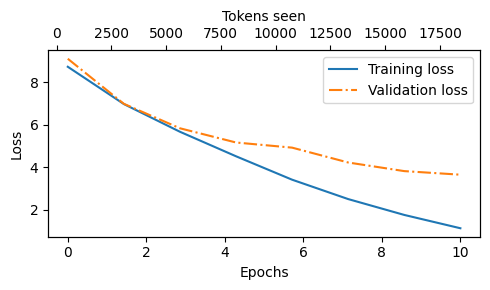

In [261]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- 查看上面的结果，我们可以看到模型一开始会生成难以理解的字符串，而到最后，它能够生成语法或多或少正确的句子
- 但是，基于训练和验证集损失，我们可以看到模型开始过度拟合
- 如果我们检查它在最后写的几段话，我们会发现它们逐字逐句地包含在训练集中——它只是记住了训练数据
- 稍后，我们将介绍可以在一定程度上减轻这种记忆的解码策略
- 请注意，这里发生过度拟合是因为我们有一个非常非常小的训练集，并且我们对其进行了多次迭代
  - 这里的 LLM 培训主要用于教育目的；我们主要想看看模型可以学会生成连贯的文本
  - 我们不是花费数周或数月在大量昂贵的硬件上训练这个模型，而是稍后加载预训练的权重

## 5.3 控制随机性的解码策略

- 使用相对较小的 LLM 作为我们上面训练的 GPT 模型，推理相对便宜，因此如果您在上面使用 GPU 进行训练，则无需使用 GPU
- 使用我们之前在简单训练函数中使用的 `generate_text_simple` 函数（来自上一章），我们可以一次生成一个新文本
- 如第 5.1.2 节所述，下一个生成的标记是词汇表中所有标记中概率得分最大的标记

In [262]:
model.to("cpu")
model.eval()

# tokenizer = tiktoken.get_encoding("gpt2")
tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("每一次努力都让你感动", tokenizer),
    max_new_tokens=50,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 每 一 次 努 力 都 让 你 感 动 在 五 分 钟 内 告 诉 你 他 是 个 不 需 要 很 长 时 间 我 的 满 足 而 感 到 高 兴 ： 很 高 兴 能 有 这 样 一 个 主 题 ， 他 的 着


- 即使我们多次执行上面的 `generate_text_simple` 函数，LLM 也始终会生成相同的输出
- 我们现在引入两个概念，即所谓的解码策略，来修改 `generate_text_simple`：*温度缩放* 和 *top-k* 采样
- 这些将允许模型控制生成文本的随机性和多样性

### 5.3.1 温度缩放

- 以前，我们总是使用 `torch.argmax` 将概率最高的标记作为下一个标记进行采样
- 为了增加多样性，我们可以使用 `torch.multinomial(probs, num_samples=1)` 从概率分布中采样下一个标记
- 在这里，每个索引被选中的概率对应于其在输入张量中的概率

- 我们可以通过称为温度缩放的概念来控制分布和选择过程
- “温度缩放”只是一个花哨的词，用于将 logits 除以大于 0 的数字
- 在应用 softmax 后，大于 1 的温度将产生更均匀分布的标记概率
- 在应用 softmax 后，小于 1 的温度将产生更可信（更尖锐或更尖锐）的分布

### 5.3.2 Top-k 抽样

- 为了能够使用更高的温度来增加输出多样性并降低无意义句子的概率，我们可以将采样的标记限制为前 k 个最可能的标记：

### 5.3.3 修改文本生成函数

- 前两小节介绍了温度采样和 top-k 采样
- 让我们使用这两个概念修改我们之前通过 LLM 生成文本时使用的 `generate_simple` 函数，创建一个新的 `generate` 函数：

In [263]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [268]:
torch.manual_seed(42)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("每一次努力都让你", tokenizer),
    max_new_tokens=50,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 每 一 次 努 力 都 让 你 ， 他 在 看 但 这 会 那 生 了 他 而 且 有 人 。 画 下 第 一 他 已 经 有 二 十 上 的 作 品 ； 果 会 ， 这 里 时 候 逐 要 么 时 ， 娶 他 ； 他 只 是


## 5.4 在 PyTorch 中加载和保存模型权重

- 训练 LLM 的计算成本很高，因此保存和加载 LLM 权重的能力至关重要
- PyTorch 中推荐的方式是通过将 `torch.save` 函数应用于 `.state_dict()` 方法来保存模型权重，即所谓的 `state_dict`：

- 通常使用 Adam 或 AdamW 等自适应优化器来训练 LLM，而不是使用常规的 SGD
- 这些自适应优化器会为每个模型权重存储额外的参数，因此如果我们计划稍后继续进行预训练，那么保存这些参数也是有意义的：

In [269]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, 
    "model_and_optimizer.pth"
)

- 然后我们可以将模型权重加载到新的 `GPTModel` 模型实例中，如下所示：

In [270]:
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();